In [2]:
import snntorch as snn
from snntorch import spikeplot as splt
from snntorch import spikegen, surrogate

import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance_matrix

from hnn_core.network import _create_cell_coords
from hnn_core.cell import _calculate_gaussian

from joblib import Parallel, delayed

spike_grad = surrogate.fast_sigmoid(slope=25)

def make_weight_matrix(n_src, n_target, w_min=0.0, w_max=1.0, prob=0.5, seed=0):
    torch.manual_seed(seed)
    prob_mask = (torch.rand((n_src, n_target)) < prob).float()
    weight_matrix = torch.rand((n_src, n_target)) * (w_max - w_min) + w_min

    return weight_matrix * prob_mask

--No graphics will be displayed.


In [3]:
class model_network(nn.Module):
    def __init__(self, snn_dict, neuron_dict, conn_dict, rec_dict, num_steps=500, device='cpu'):
        super(model_network, self).__init__()
        self.snn_dict = snn_dict
        self.neuron_dict = neuron_dict
        self.conn_dict = conn_dict
        self.weight_dict = dict()
        self.delay_dict = dict()
        self.buffer_dict = dict()
        self.neuron_indices_dict = dict()

        for conn_name in self.conn_dict.keys():
            self.weight_dict[conn_name] = self.conn_dict[conn_name]['weight'].requires_grad_(True)
            self.delay_dict[conn_name] = self.conn_dict[conn_name]['delay'].astype(int)
            # Storage for delayed spikes
            self.buffer_dict[conn_name] = torch.zeros(
                (num_steps, self.neuron_dict[self.conn_dict[conn_name]['src']]['num_neuron'],
                 self.neuron_dict[self.conn_dict[conn_name]['target']]['num_neuron']))
            
            delay_indices = np.indices(self.delay_dict[conn_name].shape)
            neuron_indices = np.vstack([delay_indices[0].flatten(), delay_indices[1].flatten()]).T
            self.neuron_indices_dict[conn_name] = neuron_indices


        self.weight_dict = nn.ParameterDict(self.weight_dict)
        self.rec_dict = rec_dict
        self.num_steps = num_steps

    def forward(self):
        self.rec_init()
        # network simulation
        for step in range(1, self.num_steps):
            for target_name in self.neuron_dict.keys():
                cur = torch.matmul(self.rec_dict[target_name]['spk_bkg'][step-1, :],
                                    self.neuron_dict[target_name]['bkg_weight'])
                

                for src_name in self.neuron_dict.keys():
                    conn_name = f'{src_name}{target_name}'
                    weight = self.weight_dict[conn_name]
                    delay_mat = self.delay_dict[conn_name]

                    neuron_indices = self.neuron_indices_dict[conn_name]
                    delays_unrolled = delay_mat[neuron_indices[:,0], neuron_indices[:,1]]
                    delay_mask = (step + delays_unrolled) < self.num_steps
                    src_spk = self.rec_dict[src_name]['spk'][step-1, :]
                    src_spk = src_spk.tile((self.neuron_dict[target_name]['num_neuron'], 1)).T

                    self.buffer_dict[conn_name][
                        (step - 1 + delays_unrolled[delay_mask]),
                        neuron_indices[delay_mask, 0],
                        neuron_indices[delay_mask,1]] = src_spk[
                            neuron_indices[delay_mask, 0],
                            neuron_indices[delay_mask,1]]

                    cur += torch.sum(self.buffer_dict[conn_name][step-1, :, :] * weight, axis=0)

                spk, mem = self.snn_dict[target_name](cur, self.rec_dict[target_name]['mem'][step-1, :])

                self.rec_dict[target_name]['mem'][step, :] = mem

                self.rec_dict[target_name]['spk'][step, :] = spk

        # # convert lists to tensors
        # for cell_name in self.snn_dict.keys():
        #     self.rec_dict[cell_name]['mem'] = torch.stack(self.rec_dict[cell_name]['mem']).squeeze()
        #     self.rec_dict[cell_name]['spk'] = torch.stack(self.rec_dict[cell_name]['spk']).squeeze()
                
        return self.rec_dict

    def rec_init(self):
        for cell_name in self.snn_dict.keys():
            cur = torch.matmul(self.rec_dict[cell_name]['spk_bkg'][0], self.neuron_dict[cell_name]['bkg_weight'])
            spk, mem = self.snn_dict[cell_name](cur, self.snn_dict[cell_name].init_leaky())

            self.rec_dict[cell_name]['mem'] = torch.zeros(self.num_steps, self.neuron_dict[cell_name]['num_neuron'])
            self.rec_dict[cell_name]['spk'] = torch.zeros(self.num_steps, self.neuron_dict[cell_name]['num_neuron'])

            self.rec_dict[cell_name]['mem'][0, :] = mem
            self.rec_dict[cell_name]['spk'][0, :] = spk


            # self.rec_dict[cell_name]['mem'] = [mem]
            # self.rec_dict[cell_name]['spk'] = [spk]

def make_network():
    delay = 1.0
    lamtha = 5.0
    pos_dict_hnn = _create_cell_coords(n_pyr_x=10, n_pyr_y=10, zdiff=1, inplane_distance=1)
    pos_dict = {'E': pos_dict_hnn['L2_pyramidal'], 'I': pos_dict_hnn['L2_basket']}
    
    n_E = len(pos_dict['E'])
    n_I = len(pos_dict['I'])
    num_steps = 1000

    neuron_dict = {
        'E': {'threshold': 1.0, 'beta': 0.99, 'num_neuron': n_E, 'bkg_prob': 0.9, 'bkg_min': 0.0, 'bkg_max': 0.3, 'bkg_rate': 0.1},
        'I': {'threshold': 1.0, 'beta': 0.99, 'num_neuron': n_I, 'bkg_prob': 0.9, 'bkg_min': 0.0, 'bkg_max': 0.8, 'bkg_rate': 0.1},
    }

    conn_dict = {
        'EI': {'w_min': 0.0, 'w_max': 5.0, 'prob': 0.8, 'src': 'E', 'target': 'I'},
        'IE': {'w_min': -5.0, 'w_max': -0.0, 'prob': 0.8, 'src': 'I', 'target': 'E'},
        'EE': {'w_min': 0.0, 'w_max': 5.0, 'prob': 0.1, 'src': 'E', 'target': 'E'},
        'II': {'w_min': -5.0, 'w_max': 0.0, 'prob': 0.8, 'src': 'I', 'target': 'I'},
    }

    snn_dict = dict()
    rec_dict = dict()
    
    seed_count = 0
    for src_name, src_dict in neuron_dict.items():
        # snn_dict[src_name] = snn.Leaky(beta=src_dict['beta'], threshold=src_dict['threshold'], spike_grad=spike_grad)
        snn_dict[src_name] = snn.Lapicque(beta=src_dict['beta'], threshold=src_dict['threshold'], spike_grad=spike_grad)

        src_pos = pos_dict[src_name]

        spk_bkg = spikegen.rate_conv(torch.ones((num_steps, src_dict['num_neuron'])) * src_dict['bkg_rate']).unsqueeze(1)
        # spk_bkg.requires_grad_(True)

        bkg_weight = make_weight_matrix(
                        n_src=src_dict['num_neuron'],
                        n_target=src_dict['num_neuron'],
                        w_min=src_dict['bkg_min'],
                        w_max=src_dict['bkg_max'],
                        prob=src_dict['bkg_prob'],
                        seed=seed_count).requires_grad_(True)
        # bkg_weight.requires_grad_(True)
        neuron_dict[src_name]['bkg_weight'] = bkg_weight

        seed_count += 1
        rec_dict[src_name] = {'mem': list(), 'spk': list(), 'spk_bkg': spk_bkg}
        for target_name, target_dict in neuron_dict.items():
            conn_name = f'{src_name}{target_name}'
            target_pos = pos_dict[target_name]
            conn_dict[conn_name]['weight'] = make_weight_matrix(
                n_src=src_dict['num_neuron'],
                n_target=target_dict['num_neuron'],
                w_min=conn_dict[conn_name]['w_min'],
                w_max=conn_dict[conn_name]['w_max'],
                prob=conn_dict[conn_name]['prob'],
                seed=seed_count
            )

            
            delay_mat = delay / _calculate_gaussian(distance_matrix(src_pos, target_pos), 1, lamtha)
            conn_dict[conn_name]['delay'] = delay_mat
            
        seed_count += 1

    net = model_network(snn_dict, neuron_dict, conn_dict, rec_dict, num_steps=num_steps)

    return net

In [7]:
net = make_network()


In [11]:
Parallel(n_jobs=32)(delayed(net)() for _ in range(32))

[{'E': {'mem': tensor([[0.0082, 0.0152, 0.0091,  ..., 0.0101, 0.0064, 0.0099],
           [0.0163, 0.0303, 0.0180,  ..., 0.0201, 0.0127, 0.0196],
           [0.0214, 0.0402, 0.0221,  ..., 0.0245, 0.0169, 0.0266],
           ...,
           [0.0459, 0.0089, 0.6895,  ..., 0.8237, 0.8897, 0.0920],
           [0.0571, 0.0259, 0.6959,  ..., 0.8280, 0.8956, 0.1048],
           [0.0693, 0.0390, 0.6816,  ..., 0.8279, 0.8994, 0.1165]],
          requires_grad=True),
   'spk': tensor([[0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           ...,
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.],
           [0., 0., 0.,  ..., 0., 0., 0.]], requires_grad=True),
   'spk_bkg': tensor([[[0., 0., 0.,  ..., 0., 0., 0.]],
   
           [[0., 0., 0.,  ..., 0., 0., 0.]],
   
           [[0., 0., 0.,  ..., 0., 0., 0.]],
   
           ...,
   
           [[0., 0., 0.,  ..., 1., 0., 0.]],
   
        

In [200]:
out = net()

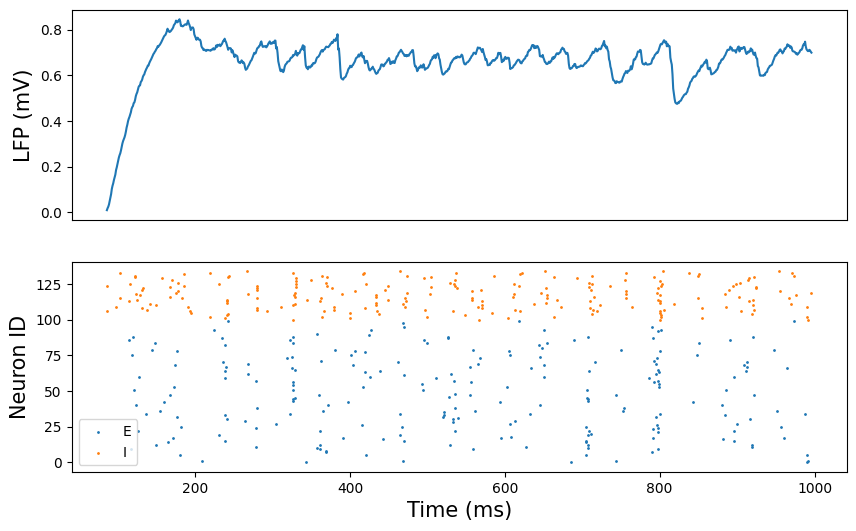

In [201]:
fontsize=15
plt.figure(figsize=(10, 6))

plt.subplot(2,1,2)
neuron_count = 0
mem_list = list()
for cell_name in net.snn_dict.keys():
    t_idx, unit_idx = np.where(net.rec_dict[cell_name]['spk'].detach().numpy() == 1.0)
    plt.scatter(t_idx, unit_idx + neuron_count, s=1, label=cell_name)

    neuron_count += net.neuron_dict[cell_name]['num_neuron']

    mem_list.append(net.rec_dict[cell_name]['mem'])

plt.legend()
plt.xlabel('Time (ms)', fontsize=fontsize)
plt.ylabel('Neuron ID', fontsize=fontsize)

plt.subplot(2,1,1)
plt.plot(torch.concat(mem_list,dim=1).mean(dim=1).detach().numpy())
plt.ylabel('LFP (mV)', fontsize=fontsize)
_ = plt.xticks([])



In [26]:
lr = 0.1
weight_decay = 0.0
optimizer = torch.optim.Adam(net.weight_dict.parameters(), lr=lr, weight_decay=weight_decay)

In [27]:
max_epochs = 100
print_freq = 1
losses = list()

for epoch in range(max_epochs):
    net.train()
    optimizer.zero_grad()

    out = net()

    lfp = torch.concat([out[cell_name]['mem'] for cell_name in out.keys()], dim=1).mean(dim=1)
    out_fft = torch.fft.rfft(lfp).abs() ** 2
    freq = torch.fft.rfftfreq(lfp.size(0), 1 / 1e3)


    power = torch.sum(out_fft[torch.logical_and(freq > 80, freq < 100)])
    denom = torch.sum(out_fft[torch.logical_and(freq < 80, freq > 0)]) + torch.sum(out_fft[torch.logical_and(freq < 200, freq > 100)])

    # relative_power = - torch.log(power)

    relative_power = - power / denom

    relative_power.backward()
    optimizer.step()

    losses.append(relative_power.item())

    #Print Loss Scores
    if (epoch+1)%print_freq == 0:
        print('')
        print('Epoch: {}/{} ...'.format(epoch+1, max_epochs), end=' ')
        print('Relative Power: {:.4f}'.format(-relative_power))

    else:
        print('*', end='')

RuntimeError: a leaf Variable that requires grad is being used in an in-place operation.

In [5]:
mask = np.logical_and(freq > 5, freq < 100).numpy().astype(bool)
plt.plot(freq.detach().cpu().numpy()[mask], out_fft.detach().cpu().numpy()[mask])
plt.xlabel('Frequency (Hz)')
plt.ylabel('Power')

NameError: name 'freq' is not defined

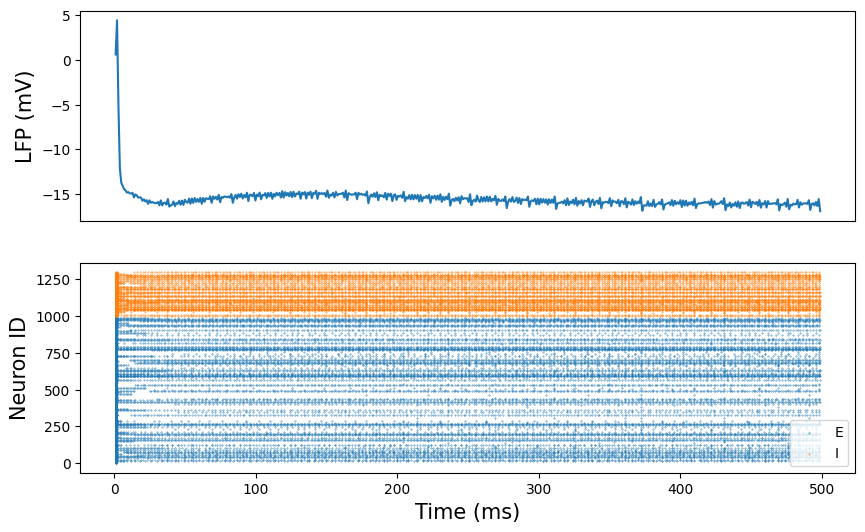

In [180]:
fontsize=15
plt.figure(figsize=(10, 6))

plt.subplot(2,1,2)
neuron_count = 0
mem_list = list()
for cell_name in net.snn_dict.keys():
    t_idx, unit_idx = np.where(net.rec_dict[cell_name]['spk'].detach().numpy() == 1.0)
    plt.scatter(t_idx, unit_idx + neuron_count, s=0.1, label=cell_name)

    neuron_count += net.neuron_dict[cell_name]['num_neuron']

    mem_list.append(net.rec_dict[cell_name]['mem'])

plt.legend()
plt.xlabel('Time (ms)', fontsize=fontsize)
plt.ylabel('Neuron ID', fontsize=fontsize)

plt.subplot(2,1,1)
plt.plot(torch.concat(mem_list,dim=1).mean(dim=1).detach().numpy())
plt.ylabel('LFP (mV)', fontsize=fontsize)
_ = plt.xticks([])

